In [3]:
import numpy as np

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from utils import dataset2numclasses

%load_ext autoreload
%autoreload 2

-1.3476889


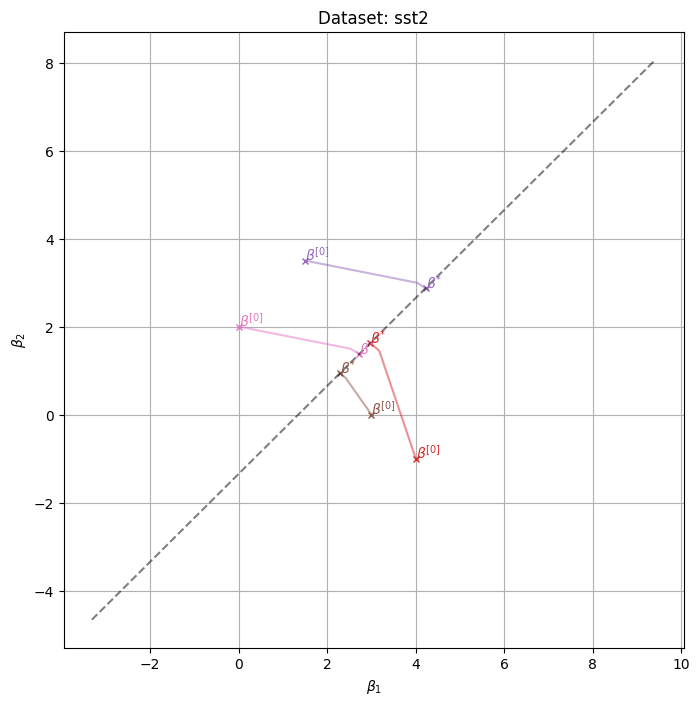

In [12]:


def plot_results(dataset, results_dirs, plot_gradient=False):

    num_classes = dataset2numclasses[dataset]

    if num_classes == 2:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    elif num_classes == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    beta_final = []
    rs = np.random.RandomState(1234)
    for results_dir, color in zip(results_dirs, rs.choice([c for c in mcolors.TABLEAU_COLORS], len(results_dirs), replace=True)):
        beta_history = np.load(os.path.join("../results",f"dataset={dataset}",results_dir,"beta_history.npy"))
        jacobian_history = np.load(os.path.join("../results",f"dataset={dataset}",results_dir,"jacobian_history.npy"))

        # Plot in 2-D
        if num_classes == 2:

            ax.plot(beta_history[:,0], beta_history[:,1], linestyle='-', alpha=0.5, color=color)
            
            ax.plot(beta_history[0,0], beta_history[0,1], marker='x', markersize=5, color=color)
            ax.text(beta_history[0,0], beta_history[0,1], r"$\beta^{[0]}$", fontsize=10, color=color)
            
            ax.plot(beta_history[-1,0], beta_history[-1,1], marker='x', markersize=5, color=color)
            ax.text(beta_history[-1,0], beta_history[-1,1], r"$\beta^{*}$", fontsize=10, color=color)

            if plot_gradient:
                # Jacobian at last step
                eigvals, eigvecs = np.linalg.eig(jacobian_history[-1])
                unstable_eigvec = eigvecs[:, np.argmin(np.abs(eigvals))]
                ax.arrow(beta_history[-1,0], beta_history[-1,1], unstable_eigvec[0], unstable_eigvec[1], 
                            head_width=0.05, head_length=0.1, fc="black", ec="black", alpha=0.5)
        
        # Plot in 3-D
        elif num_classes == 3:

            ax.plot(beta_history[:,0], beta_history[:,1], beta_history[:,2], linestyle='-', alpha=0.5, color=color)

            ax.plot(beta_history[0,0], beta_history[0,1], beta_history[0,2], marker='x', markersize=5, color=color)
            ax.text(beta_history[0,0], beta_history[0,1], beta_history[0,2], r"$\beta^{[0]}$", fontsize=10, color=color)

            ax.plot(beta_history[-1,0], beta_history[-1,1], beta_history[-1,2], marker='x', markersize=5, color=color)
            ax.text(beta_history[-1,0], beta_history[-1,1], beta_history[-1,2], r"$\beta^{*}$", fontsize=10, color=color)

            if plot_gradient:
                # Jacobian at last step
                eigvals, eigvecs = np.linalg.eig(jacobian_history[-1])
                unstable_eigvec = eigvecs[:, np.argmin(np.abs(eigvals))]
                ax.quiver(beta_history[-1,0], beta_history[-1,1], beta_history[-1,2], unstable_eigvec[0], unstable_eigvec[1], unstable_eigvec[2], 
                            length=0.1, normalize=True, color='black', alpha=0.5)

        beta_final.append(beta_history[-1])

    beta_final = np.array(beta_final)

    # Fit a 1-D line to the final points
    datamean = beta_final.mean(axis=0)
    uu, dd, vv = np.linalg.svd(beta_final - datamean)
    limit_value = np.ceil(np.max(np.abs(beta_final)) + datamean.max() + 1)
    linepts = vv[0] * np.mgrid[-limit_value:limit_value:2j][:, np.newaxis]
    linepts += datamean
    print(datamean[1] - datamean[0]/vv[0][0] * vv[0][1])
    
    # Plot the fitted line
    if num_classes == 2:
        ax.plot(linepts[:,0], linepts[:,1], linestyle='--', color='black', alpha=0.5)
    elif num_classes == 3:
        ax.plot(linepts[:,0], linepts[:,1], linepts[:,2], linestyle='--', color='black', alpha=0.5)
                
    if num_classes == 2:
        ax.set_xlabel(r"$\beta_1$")
        ax.set_ylabel(r"$\beta_2$")
    elif num_classes == 3:
        ax.set_xlabel(r"$\beta_1$")
        ax.set_ylabel(r"$\beta_2$")
        ax.set_zlabel(r"$\beta_3$")

    ax.set_title(f"Dataset: {dataset}")
    ax.grid(True)

    return fig, ax   


dataset = "sst2"
# dataset = "mnli"            
# dataset = "dogs-vs-cats"

fig, ax = plot_results(
    dataset=dataset, 
    results_dirs=os.listdir(f"../results/dataset={dataset}/"),
    plot_gradient=False
)

# Metric computation

In [5]:
from utils import compute_metric, SUCPA
from collections import defaultdict
import pandas as pd
import torch
import matplotlib.pyplot as plt

split = "train"
dataset = "dogs-vs-cats"
steps = 500
bootstrap = 100
random_state = 871283
logits = torch.from_numpy(np.load(f"../data/dogs-vs-cats/{split}_logits.npy"))
labels = torch.from_numpy(np.load(f"../data/dogs-vs-cats/{split}_labels.npy"))

metrics = ["norm_cross_entropy", "accuracy"]
results = defaultdict(list)
for metric in metrics:
    for d in os.listdir(f"../results/dataset={dataset}/"):
        if f"steps={steps}" in d:
            model = SUCPA.load_from_disk(os.path.join(f"../results/dataset={dataset}", d))
            cal_logits = model.calibrate(logits)
            uncal_metric = compute_metric(logits, labels, metric, bootstrap=True, n_boots=bootstrap, random_state=random_state)
            cal_metric = compute_metric(cal_logits, labels, metric, bootstrap=True, n_boots=bootstrap, random_state=random_state)
            results["metric"].extend([metric for _ in range(bootstrap)])
            results["uncal_logits"].extend(uncal_metric)
            results["cal_logits"].extend(cal_metric)
results = pd.DataFrame(results)

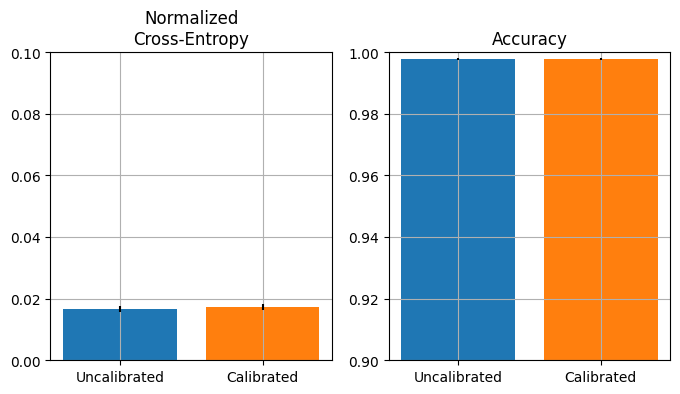

In [6]:
short_metrics = {
    "norm_cross_entropy": {"name": "Normalized\nCross-Entropy", "ylim": (0, 0.1)},
    "accuracy": {"name": "Accuracy", "ylim": (0.9, 1)}
}

fig, axes = plt.subplots(1, len(metrics), figsize=(8, 4))
bars = results.groupby("metric").agg(["mean", "std"])
for metric, ax in zip(metrics, axes):
    ax.bar([0], bars.loc[metric, ("uncal_logits", "mean")], yerr=bars.loc[metric, ("uncal_logits", "std")])
    ax.bar([1], bars.loc[metric, ("cal_logits", "mean")], yerr=bars.loc[metric, ("cal_logits", "std")])
    ax.set_title(short_metrics[metric]["name"])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Uncalibrated", "Calibrated"])
    ax.set_ylim(short_metrics[metric]["ylim"])
    ax.grid(True)